 1. Для реализованной модели градиентного бустинга построить графики зависимости ошибки от количества деревьев в ансамбле и от максимальной глубины деревьев. Сделать выводы о зависимости ошибки от этих параметров.

In [1]:
from sklearn.tree import DecisionTreeRegressor

from sklearn import model_selection
import numpy as np

import matplotlib.pyplot as plt
import matplotlib
%matplotlib inline

from sklearn.datasets import load_diabetes

In [2]:
X, y = load_diabetes(return_X_y=True)
X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y, test_size=0.25)

In [3]:
def gb_predict(X, trees_list, coef_list, eta):
    # Реализуемый алгоритм градиентного бустинга будет инициализироваться нулевыми значениями,
    # поэтому все деревья из списка trees_list уже являются дополнительными и при предсказании прибавляются с шагом eta
    return np.array([sum([eta* coef * alg.predict([x])[0] for alg, coef in zip(trees_list, coef_list)]) for x in X])

In [4]:
def mean_squared_error(y_real, prediction):
    return (sum((y_real - prediction)**2)) / len(y_real)

In [5]:
def bias(y, z):
    return (y - z)

In [6]:
def gb_fit(n_trees, max_depth, X_train, X_test, y_train, y_test, coefs, eta):
    
    # Деревья будем записывать в список
    trees = []
    
    # Будем записывать ошибки на обучающей и тестовой выборке на каждой итерации в список
    train_errors = []
    test_errors = []
    
    for i in range(n_trees):
        tree = DecisionTreeRegressor(max_depth=max_depth, random_state=42)

        # инициализируем бустинг начальным алгоритмом, возвращающим ноль, 
        # поэтому первый алгоритм просто обучаем на выборке и добавляем в список
        if len(trees) == 0:
            # обучаем первое дерево на обучающей выборке
            tree.fit(X_train, y_train)
            
            train_errors.append(mean_squared_error(y_train, gb_predict(X_train, trees, coefs, eta)))
            test_errors.append(mean_squared_error(y_test, gb_predict(X_test, trees, coefs, eta)))
        else:
            # Получим ответы на текущей композиции
            target = gb_predict(X_train, trees, coefs, eta)
            
            # алгоритмы начиная со второго обучаем на сдвиг
            tree.fit(X_train, bias(y_train, target))
            
            train_errors.append(mean_squared_error(y_train, gb_predict(X_train, trees, coefs, eta)))
            test_errors.append(mean_squared_error(y_test, gb_predict(X_test, trees, coefs, eta)))

        trees.append(tree)
        
    return trees, train_errors, test_errors

In [7]:
# Число деревьев в ансамбле
n_trees = [_ for _ in range(1, 56)]

# Максимальная глубина деревьев
max_depth = 3

# Шаг
eta = 0.1

train_errors_list = []
test_errors_list = []

for n_tree in n_trees:
    # для простоты примем коэффициенты равными 1
    coefs = [1] * n_tree
    trees, train_errors, test_errors = gb_fit(n_tree, max_depth, X_train, X_test, y_train, y_test, coefs, eta)
    train_errors_list.append(train_errors)
    test_errors_list.append(test_errors)

In [8]:
# функция построения графика зависимости ошибки от количества деревьев в ансамбле
def get_tree_num_plot(n_trees, train_err, test_err):
    plt.xlabel('Tree number')
    plt.ylabel('MSE')
    plt.plot(n_trees, train_err, label='train error')
    plt.plot(n_trees, test_err, label='test error')
    plt.legend(loc='upper right')
    plt.show()

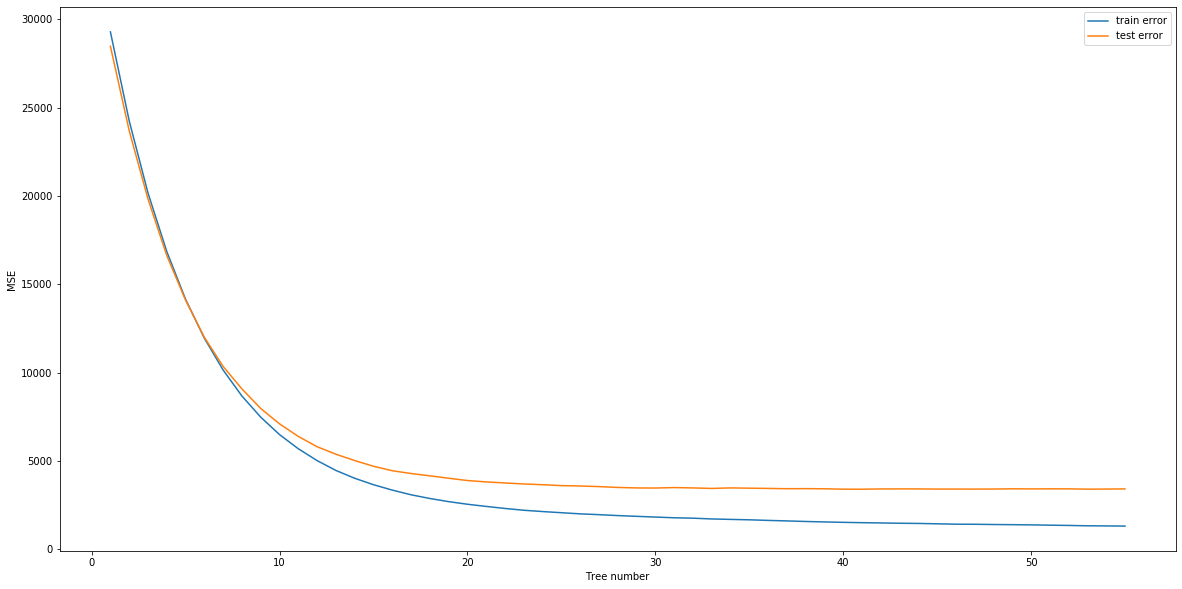

In [9]:
plt.figure(figsize=(20,10))
get_tree_num_plot(n_trees, train_errors_list[-1], test_errors_list[-1])

In [10]:
# Число деревьев в ансамбле, возьмем 10
n_trees = 10
coefs = [1] * n_trees

# Максимальная глубина деревьев
max_depth = [_ for _ in range(1, 21)]

# Шаг
eta = 0.1

train_errors_depth_list = []
test_errors_depth_list = []
for depth in max_depth:
    trees, train_errors, test_errors = gb_fit(n_trees, depth, X_train, X_test, y_train, y_test, coefs, eta)
    train_errors_depth_list.append(train_errors[-1])
    test_errors_depth_list.append(test_errors[-1])

In [11]:
# функция построения графика зависимости ошибки от максимальной глубины деревьев
def get_depth_plot(max_depth, train_err, test_err):
    plt.xlabel('Max depth')
    plt.ylabel('MSE')
    plt.plot(max_depth, train_err, label='train error')
    plt.plot(max_depth, test_err, label='test error')
    plt.legend(loc='upper right')
    plt.show()

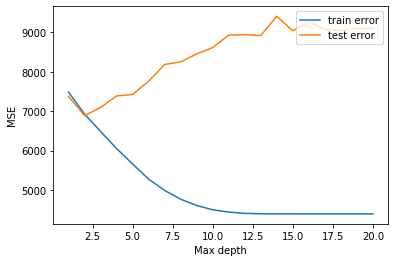

In [12]:
get_depth_plot(max_depth, train_errors_depth_list, test_errors_depth_list)

Видим, что с ростом количества деревьев среднеквадратическая ошибка существенно снижается и по тестовой, и по обучающей выборке, точка их пересечения достигается примерно при построении 8 деревьев, далее скорость снижения ошибки замедляется и значения расходятся, так как ошибка на тренировочной выборке начинает снижаться быстрее, чем на тестовой.

При изменении максимальной глубины оптимум достигается при значении 3, далее ошибка на тренировочной выборке продолжается снижаться, а на тестовой начинает расти, то есть модель переобучается.

 2*. Модифицировать реализованный алгоритм, чтобы получился стохастический градиентный бустинг. Размер подвыборки принять равным 0.5. Сравнить на одном графике кривые изменения ошибки на тестовой выборке в зависимости от числа итераций.

In [13]:
# Как и в случае с градиентым спуском, есть так называемый стохастический градиентный бустинг, являющийся упрощенной 
# (в плане потребления ресурсов) версией алгоритма. Его суть заключается в обучении каждого нового базового алгоритма 
# на новой итерации не на всей обучающей выборке, а на некоторой ее случайной подвыборке.

def sgb_fit(n_trees, max_depth, X_train, X_test, y_train, y_test, coefs, eta):
    
    # Деревья будем записывать в список
    s_trees = []
    
    # Будем записывать ошибки на обучающей и тестовой выборке на каждой итерации в список
    s_train_errors = []
    s_test_errors = []
    
    for i in range(n_trees):
        s_tree = DecisionTreeRegressor(max_depth=max_depth, random_state=42)

        # инициализируем бустинг начальным алгоритмом, возвращающим ноль, 
        # поэтому первый алгоритм просто обучаем на выборке и добавляем в список
        if len(s_trees) == 0:
            # обучаем первое дерево на обучающей выборке
            s_tree.fit(X_train, y_train)
            
            s_train_errors.append(mean_squared_error(y_train, gb_predict(X_train, s_trees, coefs, eta)))
            s_test_errors.append(mean_squared_error(y_test, gb_predict(X_test, s_trees, coefs, eta)))
        else:
            # Получим ответы на текущей композиции
            target = gb_predict(X_train, s_trees, coefs, eta)
            
            # Сгенерируем индексы для случайной подвыборки и выберем элементы
            indexes = np.random.randint(0, len(X_train), size = int(len(X_train)/2))
            X_train_part = np.array([X_train[i] for i in indexes])
            y_train_part = np.array([y_train[i] for i in indexes])
            target_part = np.array([target[i] for i in indexes])
            
            # алгоритмы начиная со второго обучаем на сдвиг
            s_tree.fit(X_train_part, bias(y_train_part, target_part))
            
            s_train_errors.append(mean_squared_error(y_train_part, gb_predict(X_train_part, s_trees, coefs, eta)))
            s_test_errors.append(mean_squared_error(y_test, gb_predict(X_test, s_trees, coefs, eta)))

        s_trees.append(s_tree)
        
    return s_trees, s_train_errors, s_test_errors

In [14]:
def get_error_plot(n_trees, train_err, test_err):
    plt.xlabel('Iteration number')
    plt.ylabel('MSE')
    plt.xlim(0, n_trees)
    plt.plot(list(range(n_trees)), train_err, label='train error')
    plt.plot(list(range(n_trees)), test_err, label='test error')
    plt.legend(loc='upper right')
    plt.show()

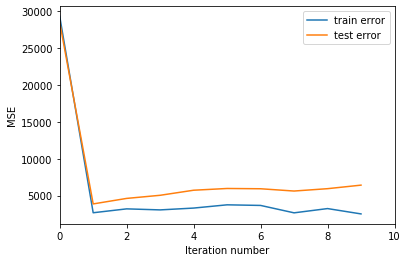

In [15]:
n_trees = 10
coefs = [1] * n_trees
max_depth = 3
eta = 1
s_trees, s_train_errors, s_test_errors = sgb_fit(n_trees, max_depth, X_train, X_test, y_train, y_test, coefs, eta)
get_error_plot(n_trees, s_train_errors, s_test_errors)

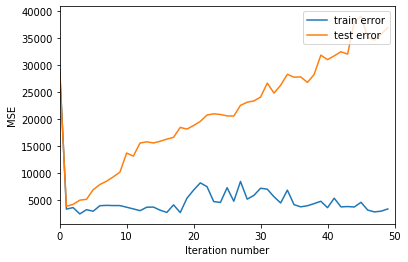

In [16]:
n_trees = 50
coefs = [1] * n_trees
max_depth = 3
eta = 1
s_trees, s_train_errors, s_test_errors = sgb_fit(n_trees, max_depth, X_train, X_test, y_train, y_test, coefs, eta)
get_error_plot(n_trees, s_train_errors, s_test_errors)

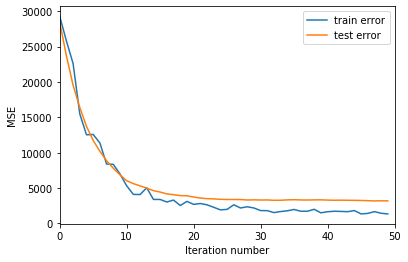

In [17]:
n_trees = 50
coefs = [1] * n_trees
max_depth = 3
eta = 0.1
s_trees, s_train_errors, s_test_errors = sgb_fit(n_trees, max_depth, X_train, X_test, y_train, y_test, coefs, eta)
get_error_plot(n_trees, s_train_errors, s_test_errors)

Видим, что графики имеют те же тенденции, что и при градиентном спуске, но при этом они неровные, со скачками. Скорость вычислений заметно выше.